# What drives giant number fluctuations?

We have shown in previous analysis that the convection flow field correlates with the local density fluctuation field best, among all the flow derivatives. However, highest correlation does not necessarily imply convection is the driving force, because the high correlation could just result from a simple mechanism: concentration gradient drives velocity. The magnitude may also not be the dominant one among all the flow derivatives. Indeed, our calculation shows that the divergence field is order of magnitude larger than the convection field. 

In this notebook, I want to further support, or disprove, the idea that convection is the driving force. To do that, I compare the direction of velocity and concentration gradient. The if the directions are mostly opposite, convection is likely to be cause of GNF. Otherwise, convection is surely not. 

## 1 Packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from corr_utils import *
import typesetting.main as tm
tm.prl('1-column-2-panel')
from skimage import io
import corrLib

# 2 Velocity and concentration gradient

In [42]:
# take 08032020/01 frame 3000 as an example
n = 2900
piv_folder = r'E:\moreData\08032020\piv_imseq\05'
img_folder = r'E:\moreData\08032020\05\8-bit'
step = 25
pivData = pd.read_csv(os.path.join(piv_folder, '{0:04d}-{1:04d}.csv'.format(n, n+1)))
x = pivData.x.drop_duplicates()
y = pivData.y.drop_duplicates()
shape = (len(y), len(x))
u = np.array(pivData.u).reshape(shape)
v = np.array(pivData.v).reshape(shape)
img = io.imread(os.path.join(img_folder, '{:04d}.tif'.format(n)))
X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
dcx = np.gradient(I, -step, axis=1)
dcy = np.gradient(I, -step, axis=0)
du = np.gradient(u, step, axis=1)
dv = np.gradient(v, step, axis=0)

In [18]:
prod = dcx * du + dcy * dv
prod = prod / abs(prod)

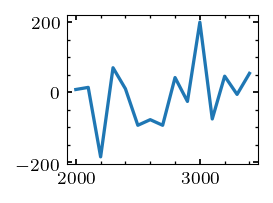

In [22]:
prod_list = []
t = range(2000, 3500, 100)
for n in t:
    pivData = pd.read_csv(os.path.join(piv_folder, '{0:04d}-{1:04d}.csv'.format(n, n+1)))
    u = np.array(pivData.u).reshape(shape)
    v = np.array(pivData.v).reshape(shape)
    img = io.imread(os.path.join(img_folder, '{:04d}.tif'.format(n)))
    X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
    dcx = np.gradient(I, -step, axis=1)
    dcy = np.gradient(I, -step, axis=0)
    du = np.gradient(u, step, axis=1)
    dv = np.gradient(v, step, axis=0)
    prod = dcx * du + dcy * dv
    prod = prod / abs(prod)
    prod_list.append(np.sum(prod))
plt.plot(t, prod_list)

Whether the direction of velocity is the same as or opposite of the concentration gradient direction looks completely random. Next, let's put the magnitude of both quantities as weight.

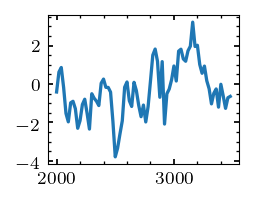

In [43]:
prod_list = []
t = range(2000, 3500, 20)
for n in t:
    pivData = pd.read_csv(os.path.join(piv_folder, '{0:04d}-{1:04d}.csv'.format(n, n+1)))
    u = np.array(pivData.u).reshape(shape)
    v = np.array(pivData.v).reshape(shape)
    img = io.imread(os.path.join(img_folder, '{:04d}.tif'.format(n)))
    X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
    dcx = np.gradient(-I, step, axis=1)
    dcy = np.gradient(-I, step, axis=0)
    du = np.gradient(u, step, axis=1)
    dv = np.gradient(v, step, axis=0)
    prod = dcx * du + dcy * dv
    prod_list.append(np.sum(prod))
plt.plot(t, prod_list)

In [44]:
np.array(prod_list).sum()

-25.706796291601187